# Methanol Synthesis Flowsheet Example
## Simplified Hydrogen Reformation System

This example demonstrates a steady-state simulation of methanol synthesis from hydrogen and carbon monoxide. To simulate relevant natural gas components, the reactant vapors are mixed stoichiometrically and brought to optimal reaction conditions prior to entering the gas-phase reactor. Vapor liquid equilibrium is mainly applicable in the post-reactor Flash unit for methanol recovery, and is accounted for by the thermophysical properties. Water is included as a component to assist with VLE calculations. See the relevant methanol synthesis modules in `idaes-pse\idaes.generic_models\flowsheets` and the relevant property and reaction packages in `idaes-pse\idaes\generic_models\properties\examples` for more information on how to assemble the flowsheet.

This example does not represent any particular chemical process, but should be a reasonable approximation for methanol synthesis systems employing a water-gas-shift reaction. General process descriptions for gas-phase synthesis, as well as thermophysical and reaction properties, were taken from the following publication:

Nieminen, H.; Laari, A.; Koiranen, T. CO2 Hydrogenation to Methanol by a Liquid-Phase Process with Alcoholic Solvents: A Techno-Economic Analysis. Processes 2019, 7, 405. https://doi.org/10.3390/pr7070405

## 1. Introduction

This example demonstrates a simulation of methanol synthesis from hydrogen and carbon monoxide. In the example flowsheets directory above, ```methanol_flowsheet.py``` includes five modules (build_model, set_inputs, initialize_flowsheet, add_costing and report). Initial optimization for a squared problem (zero degrees of freedom) occurs in the solve following ```add_costing()```. If further optimization is desired, variables must be unfixed and the flowsheet re-solved after these methods are called (as demonstrated in this notebook).

The ```build_model()``` function creates the Pyomo concrete model and builds the flowsheet by importing units and defining stream connections between these units.

The ```set_inputs()``` function adds the appropriate initial specifications on the feed streams and unit operations.

The ```initialize_flowsheet()``` function uses the initial guess to initialize the models one at a time, solving each unit and propagating the results to the outlet stream to converge the next unit more quickly. This occurs just before the flowsheet-level solver call.

The ```add_costing()``` function creates new variables and constraints related to unit capital cost and operating cost calculations, and defines an objective function for the process economics. This function is called after the flowsheet-level solver call, and the flowsheet is resolved once costing is added. Capital costs are estimated using built-in costing methods within IDAES, and operating costs are estimated from a combination of known cost coefficients and surrogate models.

The ```report()``` function displays relevant model results after the flowsheet has been fully solved.

# 2. Problem Statement 

For given raw material flows and optimal reactor conditions, calculate the extent of reaction, relevant process results including reactor duty and turbine duty, methanol recovery, and relevant economic results including annual revenue.

## 2.1. Main Inputs: 
- Raw material inlets (F - mol/s, h - j/mol)
- Pre-reactor compressor outlet pressure (Pa)
- Pre-reactor heater outlet temperature (K)

## 2.2. Main Outputs:
- Extent of reaction (mol/s)
- Reactor duty (MW)
- Turbine duty (MW)
- Methanol recovery (%)
- Annual revenue (1000 USD/year)

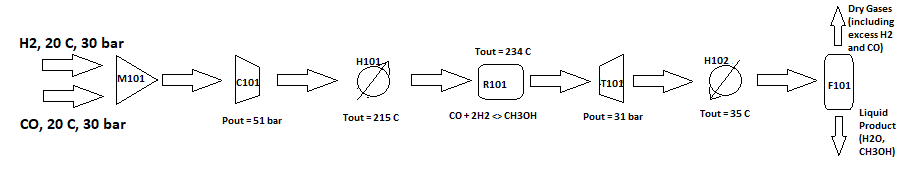

In [1]:
from IPython.display import Image
Image("methanol_flowsheet.png")

## 3. Results

In [2]:
import os
import pytest
# Import Pyomo libraries
from pyomo.environ import (Constraint,
                           Objective,
                           Var,
                           Expression,
                           ConcreteModel,
                           TransformationFactory,
                           value,
                           maximize)
from pyomo.environ import TerminationCondition
from pyomo.network import Arc
# Import IDAES core
from idaes.core import FlowsheetBlock
from idaes.core.util import get_solver
from idaes.core.util.model_statistics import degrees_of_freedom
from idaes.core.util.initialization import propagate_state

# Import IDAES standard unit, property and costing models
from idaes.generic_models.properties.core.generic.generic_property import \
    GenericParameterBlock
from idaes.generic_models.properties.core.generic.generic_reaction import \
    GenericReactionParameterBlock

from idaes.generic_models.properties.examples import \
    methanol_water_ideal as thermo_props
from idaes.generic_models.properties.examples import \
    methanol_reactions as reaction_props

from idaes.generic_models.unit_models import (
    Mixer,
    Heater,
    Compressor,
    Turbine,
    StoichiometricReactor,
    Flash)
from idaes.generic_models.unit_models.mixer import MomentumMixingType
from idaes.generic_models.unit_models.pressure_changer import \
    ThermodynamicAssumption
import idaes.core.util.unit_costing as costing

# import flowsheet functions
import idaes.generic_models.flowsheets.methanol_flowsheet as fs_method

In [3]:
# Build and solve flowsheet
solver = get_solver()
m = ConcreteModel()
fs_method.build_model(m)  # build flowsheet
optarg = {'tol': 1e-6,
          'max_iter': 5000}
solver.options = optarg
fs_method.set_inputs(m)  # unit and stream specifications
fs_method.initialize_flowsheet(m)  # rigorous initialization scheme
print('DOF before solve: ', degrees_of_freedom(m))
results = solver.solve(m, tee=True)
assert results.solver.termination_condition == TerminationCondition.optimal

fs_method.add_costing(m)  # re-solve with costing equations
results2 = solver.solve(m, tee=True)
m.fs.R101.costing.purchase_cost.display()
print('Initial solution process results:')
fs_method.report(m)  # display initial solution results

# Set up Optimization Problem (Maximize Revenue)
# keep process pre-reaction fixed and unfix some post-process specs
m.fs.R101.conversion.unfix()
m.fs.R101.conversion_lb = Constraint(expr=m.fs.R101.conversion >= 0.75)
m.fs.R101.conversion_ub = Constraint(expr=m.fs.R101.conversion <= 0.85)
m.fs.R101.outlet_temp.deactivate()
m.fs.R101.outlet_t_lb = Constraint(
    expr=m.fs.R101.control_volume.properties_out[0.0].temperature >= 405)
m.fs.R101.outlet_t_ub = Constraint(
    expr=m.fs.R101.control_volume.properties_out[0.0].temperature <= 505)

# Optimize turbine work (or delta P)
m.fs.T101.deltaP.unfix()  # optimize turbine work recovery/pressure drop
m.fs.T101.outlet_p_lb = Constraint(
    expr=m.fs.T101.outlet.pressure[0] >= 10E5)
m.fs.T101.outlet_p_ub = Constraint(
    expr=m.fs.T101.outlet.pressure[0] <= 51E5*0.8)

# Optimize Cooler outlet temperature - unfix cooler outlet temperature
m.fs.H102.outlet_temp.deactivate()
m.fs.H102.outlet_t_lb = Constraint(
    expr=m.fs.H102.control_volume.properties_out[0.0].temperature
    >= 407.15*0.8)
m.fs.H102.outlet_t_ub = Constraint(
    expr=m.fs.H102.control_volume.properties_out[0.0].temperature
    <= 480)

m.fs.F101.deltaP.unfix()  # allow pressure change in streams

m.fs.F101.isothermal = Constraint(
    expr=m.fs.F101.control_volume.properties_out[0].temperature ==
    m.fs.F101.control_volume.properties_in[0].temperature)

opt_res = solver.solve(m, tee=True)
assert opt_res.solver.termination_condition == TerminationCondition.optimal
print('Optimal solution process results:')
fs_method.report(m)

Unit degrees of freedom
M101 2
C101 2
H101 2
R101 3
T101 3
H102 2
F101 3
Total DOF:  25
DOF after streams specified:  9
DOF after units specified:  0

2022-02-15 07:19:24 [INFO] idaes.init.fs.M101.H2_WGS_state: Starting initialization
2022-02-15 07:19:24 [INFO] idaes.init.fs.M101.H2_WGS_state: Dew and bubble point initialization: optimal - Optimal Solution Found.
2022-02-15 07:19:24 [INFO] idaes.init.fs.M101.H2_WGS_state: Equilibrium temperature initialization completed.
2022-02-15 07:19:24 [INFO] idaes.init.fs.M101.H2_WGS_state: Phase equilibrium initialization: optimal - Optimal Solution Found.
2022-02-15 07:19:24 [INFO] idaes.init.fs.M101.H2_WGS_state: Property initialization: optimal - Optimal Solution Found.
2022-02-15 07:19:24 [INFO] idaes.init.fs.M101.CO_WGS_state: Starting initialization
2022-02-15 07:19:24 [INFO] idaes.init.fs.M101.CO_WGS_state: Dew and bubble point initialization: optimal - Optimal Solution Found.
2022-02-15 07:19:24 [INFO] idaes.init.fs.M101.CO_WGS_state: Eq

2022-02-15 07:19:29 [INFO] idaes.init.fs.T101.properties_isentropic: Dew and bubble point initialization: optimal - Optimal Solution Found.
2022-02-15 07:19:29 [INFO] idaes.init.fs.T101.properties_isentropic: Equilibrium temperature initialization completed.
2022-02-15 07:19:29 [INFO] idaes.init.fs.T101.properties_isentropic: Phase equilibrium initialization: optimal - Optimal Solution Found.
2022-02-15 07:19:29 [INFO] idaes.init.fs.T101.properties_isentropic: Property initialization: optimal - Optimal Solution Found.
2022-02-15 07:19:29 [INFO] idaes.init.fs.T101.properties_isentropic: Property package initialization: optimal - Optimal Solution Found.
2022-02-15 07:19:29 [INFO] idaes.init.fs.T101: Initialization Complete: optimal - Optimal Solution Found
2022-02-15 07:19:29 [INFO] idaes.init.fs.H102.control_volume.properties_in: Starting initialization
2022-02-15 07:19:30 [INFO] idaes.init.fs.H102.control_volume.properties_in: Dew and bubble point initialization: optimal - Optimal Solu

purchase_cost : Unit Purchase Cost in $
    Size=1, Index=None
    Key  : Lower : Value            : Upper : Fixed : Stale : Domain
    None :     0 : 97423.2115133701 :  None : False : False : NonNegativeReals
Initial solution process results:


Extent of reaction:  237.600477900053
Stoichiometry of each component normalized by the extent:
CH4 :  0.0
H2 :  -2.0
H2O :  0.0
CH3OH :  1.0
CO :  -1.0
These coefficients should follow 1*CO + 2*H2 => 1*CH3OH

Reaction conversion:  0.75
Reactor duty (MW):  -45.21917766260702
Duty from Reaction (MW)): 21.536107316860804
Turbine work (MW):  -0.9593364854483705
Mixer outlet temperature (C)):  20.06006796770083
Compressor outlet temperature (C)):  20.060067967708562
Compressor outlet pressure (Pa)):  5100000.0
Heater outlet temperature (C)):  215.0
Reactor outlet temperature (C)):  234.0
Turbine outlet temperature (C)):  192.8781391881422
Turbine outlet pressure (Pa)):  3099999.9999998566
Cooler outlet temperature (C)):  134.0
Flash outlet tempera

  49 -7.0157553e+07 2.78e+04 2.43e+11  -5.7 5.39e+00   0.1 5.05e-02 6.46e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 -7.0157551e+07 2.78e+04 9.53e+14  -5.7 2.21e+06    -  1.42e-09 5.58e-06f  2
  51 -7.0157551e+07 2.78e+04 9.53e+14  -5.7 1.42e+04  -0.4 1.02e-07 1.32e-07h  2
  52r-7.0157551e+07 2.78e+04 9.99e+02   0.9 0.00e+00  -0.8 0.00e+00 3.28e-07R  3
  53r-6.9561949e+07 2.78e+04 2.22e+04   0.9 1.04e+04    -  1.52e-04 9.91e-04f  1
  54 -7.7846435e+07 2.71e+05 1.48e+02  -5.7 2.80e+07    -  2.44e-01 8.07e-02f  1
  55 -7.7884022e+07 2.69e+05 1.87e+02  -5.7 4.28e+06    -  6.52e-01 6.92e-03h  1
  56 -8.1455256e+07 3.02e+05 1.54e+02  -5.7 1.28e+07    -  3.94e-01 2.37e-01f  1
  57 -8.1098501e+07 2.67e+04 3.10e+01  -5.7 4.37e+05    -  8.14e-01 9.04e-01h  1
  58 -8.1098495e+07 2.67e+04 4.55e+03  -5.7 4.00e+04    -  9.50e-01 3.53e-04h  1
  59r-8.1098495e+07 2.67e+04 1.00e+03   0.5 0.00e+00    -  0.00e+00 6.14e-10R  2
iter    objective    inf_pr 

Optimal solution process results:


Extent of reaction:  269.28054478798873
Stoichiometry of each component normalized by the extent:
CH4 :  -0.0
H2 :  -2.0
H2O :  0.0
CH3OH :  1.0
CO :  -1.0
These coefficients should follow 1*CO + 2*H2 => 1*CH3OH

Reaction conversion:  0.8500000099999442
Reactor duty (MW):  -51.36357300452574
Duty from Reaction (MW)): 24.407588579583297
Turbine work (MW):  -0.3819475675958874
Mixer outlet temperature (C)):  20.060067967690543
Compressor outlet temperature (C)):  20.060067967690486
Compressor outlet pressure (Pa)):  5100000.0
Heater outlet temperature (C)):  215.0
Reactor outlet temperature (C)):  231.8500049662734
Turbine outlet temperature (C)):  214.88214338657178
Turbine outlet pressure (Pa)):  4080000.03990529
Cooler outlet temperature (C)):  134.00000000000006
Flash outlet temperature (C)):  134.0
Methanol recovery(%):  95.54327713925954
annualized capital cost ($/year) = 586505.0927674029
operating cost ($/year) =  411348220.8474192
sales ($/yea

In [4]:
# testing model results
assert value(m.fs.R101.rate_reaction_extent[0, "R1"]) == pytest.approx(269.2805, abs=1e-2)
assert value(m.fs.R101.heat_duty[0])/1E6 == pytest.approx(-51.3636, abs=1e-2)
assert value(m.fs.T101.work_isentropic[0])/1E6 == pytest.approx(-0.3819, abs=1e-2)
assert value(m.fs.F101.recovery*100) == pytest.approx(95.5433, abs=1e-2)
assert value(m.fs.objective)/1E6 == pytest.approx(81.087730, abs=1e-2)

# 3. Problem Statement  - Analyzing Benefit of Recycling Flash Vapor

To increase the efficiency of the process as well as the overall methanol production and revenue, we can add a recycle stream to send most of the Flash vapor back to the start of the process. This will result in higher operating costs and higher production at the same conversion. Note that for conversions less than 100%, a simulation with no purge will never converge; the solver will simultaneously attempt to convert all vapors to liquid methanol in order to close the mass balance and never achieve full conversion in the reactor. Therefore, we set a lower bound at 10% purge from the Flash vapor to the exhaust. We expect to see a marginal increase in operating costs due to increased flow, and a much larger increase in overall production resulting in a higher total revenue.

By adding a recycle to the flowsheet, we significantly decrease the solvability of the problem and require a better initial guess. The SequentialDecomposition algorithm automatically determines a stream to *tear*, or use to break the solve loop, and iterates from a set of user-supplied initial guesses until converging on the optimal solution. The code below calls an initialization method to automatically determine the tear stream, and if available gather the results from a prior solved model. If not supplied, the method defaults to a feasible set of guesses (tear C101 inlet and set values from a 0% recycle solution). See `idaes-pse\idaes.generic_models\flowsheets.methanol_flowsheet_w_recycle` for further details on the methods.

For given raw material flows and optimal reactor conditions, calculate the extent of reaction, relevant process results including reactor duty and turbine duty, methanol recovery, and relevant economic results including annual revenue.

## 3.1. Main Inputs: 
- Raw material inlets (F - mol/s, h - j/mol)
- Pre-reactor compressor outlet pressure (Pa)
- Pre-reactor heater outlet temperature (K)

## 3.2. Main Outputs:
- Extent of reaction (mol/s)
- Reactor duty (MW)
- Compressor duty (MW)
- Turbine duty (MW)
- Methanol recovery (%)
- Purge percentage (%)
- Annual revenue (1000 USD/year)

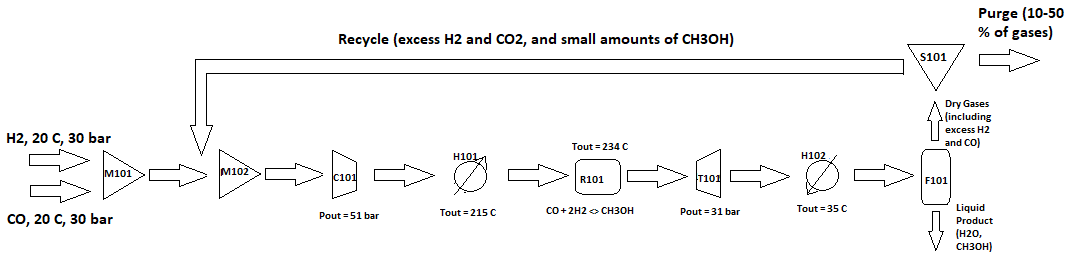

In [5]:
from IPython.display import Image
Image("methanol_flowsheet_recycle.png")

## 3. Results

In [6]:
import os
import pytest
# Import Pyomo libraries
from pyomo.environ import (Constraint,
                           Objective,
                           Var,
                           Expression,
                           ConcreteModel,
                           TransformationFactory,
                           value,
                           maximize)
from pyomo.environ import TerminationCondition
from pyomo.network import Arc
# Import IDAES core
from idaes.core import FlowsheetBlock
from idaes.core.util import get_solver
from idaes.core.util.model_statistics import degrees_of_freedom
from idaes.core.util.initialization import propagate_state

# Import IDAES standard unit, property and costing models
from idaes.generic_models.properties.core.generic.generic_property import \
    GenericParameterBlock
from idaes.generic_models.properties.core.generic.generic_reaction import \
    GenericReactionParameterBlock

from idaes.generic_models.properties.examples import \
    methanol_water_ideal as thermo_props
from idaes.generic_models.properties.examples import \
    methanol_reactions as reaction_props

from idaes.generic_models.unit_models import (
    Mixer,
    Heater,
    Compressor,
    Turbine,
    StoichiometricReactor,
    Flash)
from idaes.generic_models.unit_models.mixer import MomentumMixingType
from idaes.generic_models.unit_models.pressure_changer import \
    ThermodynamicAssumption
import idaes.core.util.unit_costing as costing

# import flowsheet functions
import idaes.generic_models.flowsheets.methanol_flowsheet_w_recycle as fs_method

In [7]:
# Build and solve flowsheet
solver = get_solver()
n = ConcreteModel()  # create a new model so we may reference 'm' below
fs_method.build_model(n)  # build flowsheet
optarg = {'tol': 1e-6,
          'max_iter': 5000}
solver.options = optarg
fs_method.set_inputs(n)  # unit and stream specifications

# let the solver determine the tear stream, and pull the guesses from the prior model solution
fs_method.initialize_flowsheet(n, solved_m=m)  # rigorous initialization scheme
print('DOF before solve: ', degrees_of_freedom(n))
results = solver.solve(n, tee=True)
assert results.solver.termination_condition == TerminationCondition.optimal

fs_method.add_costing(n)  # re-solve with costing equations
results2 = solver.solve(n, tee=True)
n.fs.R101.costing.purchase_cost.display()
print('Initial solution process results:')
fs_method.report(n)  # display initial solution results

# Set up Optimization Problem (Maximize Revenue)
# keep process pre-reaction fixed and unfix some post-process specs
n.fs.R101.conversion.unfix()
n.fs.R101.conversion_lb = Constraint(expr=n.fs.R101.conversion >= 0.75)
n.fs.R101.conversion_ub = Constraint(expr=n.fs.R101.conversion <= 0.85)
n.fs.R101.outlet_temp.deactivate()
n.fs.R101.outlet_t_lb = Constraint(
    expr=n.fs.R101.control_volume.properties_out[0.0].temperature >= 405)
n.fs.R101.outlet_t_ub = Constraint(
    expr=n.fs.R101.control_volume.properties_out[0.0].temperature <= 505)

# Optimize turbine work (or delta P)
n.fs.T101.deltaP.unfix()  # optimize turbine work recovery/pressure drop
n.fs.T101.outlet_p_lb = Constraint(
    expr=n.fs.T101.outlet.pressure[0] >= 10E5)
n.fs.T101.outlet_p_ub = Constraint(
    expr=n.fs.T101.outlet.pressure[0] <= 51E5*0.8)

# Optimize Cooler outlet temperature - unfix cooler outlet temperature
n.fs.H102.outlet_temp.deactivate()
n.fs.H102.outlet_t_lb = Constraint(
    expr=n.fs.H102.control_volume.properties_out[0.0].temperature
    >= 407.15*0.8)
n.fs.H102.outlet_t_ub = Constraint(
    expr=n.fs.H102.control_volume.properties_out[0.0].temperature
    <= 480)

n.fs.F101.deltaP.unfix()  # allow pressure change in streams

n.fs.F101.isothermal = Constraint(
    expr=n.fs.F101.control_volume.properties_out[0].temperature ==
    n.fs.F101.control_volume.properties_in[0].temperature)

n.fs.S101.split_fraction[0, "purge"].unfix()  # allow some gas recycle
n.fs.S101.split_fraction_lb = Constraint(
    expr=n.fs.S101.split_fraction[0, "purge"] >= 0.10)  # min 10% purge
n.fs.S101.split_fraction_ub = Constraint(
    expr=n.fs.S101.split_fraction[0, "purge"] <= 0.50)  # max 50% purge

opt_res = solver.solve(n, tee=True)
assert opt_res.solver.termination_condition == TerminationCondition.optimal
print('Optimal solution process results:')
fs_method.report(n)

Unit degrees of freedom
M101 2
C101 2
H101 2
R101 3
T101 3
H102 2
F101 3
M102 2
S101 2
Total DOF:  26
DOF after streams specified:  10
DOF after units specified:  0

Tear Stream:
fs.s02 :  fs.M102.outlet  to  fs.C101.inlet

Calculation order:
fs.M101
fs.H101
fs.R101
fs.T101
fs.H102
fs.F101
fs.S101
fs.M102

Tear guesses: 
{'flow_mol': {0: 954.0}, 'mole_frac_comp': {(0, 'CH4'): 1e-06, (0, 'CO'): 0.33207, (0, 'H2'): 0.66792, (0, 'CH3OH'): 1e-06, (0, 'H2O'): 1e-06}, 'enth_mol': {0: -36848.0}, 'pressure': {0: 3000000.0}}
Initial DOF =  0
Solving  fs.M101
DOF =  0
Solving  fs.C101
DOF =  0
Solving  fs.H101
DOF =  0
Solving  fs.R101
DOF =  0
Solving  fs.T101
DOF =  0
Solving  fs.H102
DOF =  0
Solving  fs.F101
DOF =  0
Solving  fs.S101
DOF =  0
Solving  fs.M102
DOF =  0
Solving  fs.M101
DOF =  0
Unfixing  fs.M102.feed ...
Final DOF =  0
DOF before solve:  0
Ipopt 3.13.2: tol=1e-06
max_iter=5000


******************************************************************************
This program contai

purchase_cost : Unit Purchase Cost in $
    Size=1, Index=None
    Key  : Lower : Value             : Upper : Fixed : Stale : Domain
    None :     0 : 97423.21151336991 :  None : False : False : NonNegativeReals
Initial solution process results:


Extent of reaction:  237.60641806045157
Stoichiometry of each component normalized by the extent:
CH4 :  0.0
H2 :  -2.0
H2O :  0.0
CH3OH :  1.0
CO :  -1.0
These coefficients should follow 1*CO + 2*H2 => 1*CH3OH

Reaction conversion:  0.75
Reactor duty (MW):  -45.220297306598255
Duty from Reaction (MW)): 21.536645732999332
Compressor work (MW):  -7.450574931384657e-15
Turbine work (MW):  -0.9593803958426027
Feed Mixer outlet temperature (C)):  20.060067967690543
Recycle Mixer outlet temperature (C)):  20.064839011841002
Feed Compressor outlet temperature (C)):  20.06483901184089
Feed Compressor outlet pressure (Pa)):  5100000.0
Heater outlet temperature (C)):  215.0
Reactor outlet temperature (C)):  234.0
Turbine outlet temperature (C)):  192

  28 -6.2545753e+07 1.82e+03 2.26e+06  -1.0 3.83e+04  -5.9 1.00e+00 2.40e-02h  5
  29 -6.2544020e+07 1.78e+03 5.26e+05  -1.0 4.00e+04  -6.4 1.00e+00 2.37e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -6.2542318e+07 1.74e+03 4.94e+05  -1.0 4.21e+04  -6.9 1.00e+00 2.35e-02h  5
  31 -6.2541177e+07 1.70e+03 5.03e+05  -1.0 4.60e+04  -7.3 1.00e+00 2.33e-02h  5
  32 -6.2544327e+07 1.66e+03 5.29e+05  -1.0 6.32e+04  -7.8 1.00e+00 2.32e-02h  5
  33 -6.2583098e+07 1.62e+03 6.06e+05  -1.0 2.02e+05  -8.3 4.42e-01 2.39e-02h  5
  34 -6.2699344e+07 1.59e+03 6.25e+05  -1.0 1.02e+06  -8.8 5.89e-03 1.14e-02f  6
  35r-6.2699344e+07 1.59e+03 1.00e+03  -1.0 0.00e+00  -9.2 0.00e+00 3.78e-07R  4
  36r-6.2711089e+07 1.43e+03 2.00e+03  -1.0 3.07e+03    -  4.90e-02 7.36e-03f  1
  37 -6.2741578e+07 1.40e+03 2.26e+04  -1.0 3.69e+05    -  7.89e-01 1.04e-02f  1
  38 -6.2741831e+07 1.39e+03 4.04e+04  -1.0 6.50e+04    -  8.70e-01 1.12e-02h  6
  39 -6.2742319e+07 1.37e+03

 121r-7.7674274e+07 9.24e+02 1.00e+03  -1.0 0.00e+00    -  0.00e+00 3.08e-07R  3
 122r-7.7680775e+07 8.99e+02 5.16e+03  -1.0 6.58e+03    -  6.81e-02 6.24e-03f  1
 123r-7.7762182e+07 8.11e+02 2.04e+03  -1.0 6.39e+03    -  2.00e-02 6.35e-02f  1
 124 -7.7755506e+07 8.04e+02 5.89e+04  -1.0 1.44e+05    -  8.51e-01 8.12e-03h  3
 125 -7.7747898e+07 7.99e+02 5.92e+04  -1.0 2.06e+05    -  1.60e-02 6.21e-03h  3
 126 -7.7741087e+07 7.92e+02 5.99e+04  -1.0 1.30e+05    -  2.78e-02 9.47e-03h  2
 127 -7.7733576e+07 7.84e+02 4.25e+06  -1.0 1.39e+05    -  9.08e-01 9.75e-03h  1
 128 -7.7733542e+07 7.84e+02 2.00e+09  -1.0 8.78e+04    -  4.67e-02 9.96e-05h  1
 129r-7.7733542e+07 7.84e+02 1.00e+03  -1.0 0.00e+00    -  0.00e+00 4.98e-07R  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130r-7.7737809e+07 7.67e+02 8.15e+03  -1.0 5.20e+03    -  1.06e-01 5.53e-03f  1
 131 -7.7735631e+07 7.65e+02 1.88e+05  -1.0 1.54e+05    -  8.52e-01 2.52e-03h  1
 132r-7.7735631e+07 7.65e+02

 228 -9.5900795e+07 6.16e-03 6.67e+07  -1.0 2.72e+02  -6.6 4.69e-02 1.00e+00f  1
 229 -9.5900285e+07 7.89e-01 5.82e+08  -1.0 4.29e+02  -7.1 1.97e-02 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 -9.6101989e+07 3.15e+01 1.89e+09  -1.0 9.15e+09    -  1.16e-06 7.80e-06f  2
 231 -9.6124418e+07 1.76e+01 9.45e+08  -1.0 2.02e+04    -  5.84e-01 5.00e-01f  2
 232 -9.6117565e+07 5.50e-01 3.31e+07  -1.0 2.82e+03    -  1.00e+00 1.00e+00h  1
 233 -9.6113015e+07 1.43e+00 1.62e+08  -1.0 1.02e+03  -6.7 1.25e-01 1.00e+00f  1
 234 -9.6109760e+07 2.59e-01 1.49e+07  -1.0 8.22e+02  -7.2 1.00e+00 1.00e+00f  1
 235 -9.6107023e+07 1.89e-01 3.56e+06  -1.0 7.86e+02  -7.6 1.00e+00 1.00e+00f  1
 236 -9.6107893e+07 5.01e-03 2.42e+07  -1.7 6.58e+02  -8.1 1.00e+00 1.00e+00f  1
 237 -9.6109992e+07 5.35e-02 1.43e+05  -1.7 1.91e+03  -8.6 1.00e+00 1.00e+00f  1
 238 -9.6129546e+07 8.48e-01 7.06e+07  -2.5 4.85e+03  -9.1 1.00e+00 1.00e+00f  1
 239 -9.6130783e+07 1.55e-02

MA27BD returned iflag=-4 and requires more memory.
 Increase liw from 38885 to 77770 and la from 53305 to 107050 and factorize again.
 327r-1.0482743e+08 4.88e-02 9.99e+02  -1.3 0.00e+00  19.3 0.00e+00 4.77e-07R 22
 328r-1.0482730e+08 4.87e-02 9.99e+02  -1.3 7.93e+05    -  5.56e-09 2.35e-06f  1
 329r-1.0482675e+08 8.03e+00 9.99e+02  -1.3 1.07e+03   0.0 4.77e-06 2.15e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 330r-1.0482659e+08 8.07e+00 9.99e+02  -1.3 5.31e+02  -0.5 2.96e-04 6.39e-05f  1
 331r-1.0482635e+08 8.02e+00 9.99e+02  -1.3 4.08e+05    -  1.27e-04 3.24e-04f  1
 332r-1.0482318e+08 7.94e+00 1.36e+03  -1.3 2.64e+04    -  5.34e-04 1.39e-03f  1
 333r-1.0481830e+08 8.34e+00 9.95e+02  -1.3 2.69e+04    -  3.51e-03 2.21e-03f  1
 334r-1.0481072e+08 1.83e+01 5.65e+03  -1.3 1.54e+04    -  2.94e-02 6.42e-03f  1
 335r-1.0478990e+08 7.84e+01 7.28e+03  -1.3 6.08e+03    -  6.43e-02 3.94e-02f  1
 336r-1.0452420e+08 8.10e+03 2.72e+04  -1.3 3.38e+03    

 445 -1.0482699e+08 5.88e-06 3.24e+02  -8.6 4.19e-15  16.9 1.00e+00 1.00e+00h  1
 446 -1.0482699e+08 4.52e-06 3.80e+02  -8.6 1.48e-14  16.4 1.00e+00 1.00e+00h  1
 447 -1.0482699e+08 4.32e-06 4.44e+02  -8.6 5.16e-14  15.9 1.00e+00 1.00e+00h  1
 448 -1.0482699e+08 7.79e-06 5.07e+02  -8.6 1.77e-13  15.5 1.00e+00 1.00e+00h  1
 449 -1.0482699e+08 1.51e-05 5.70e+02  -8.6 5.97e-13  15.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 450 -1.0482699e+08 1.21e-05 6.33e+02  -8.6 1.99e-12  14.5 1.00e+00 1.00e+00h  1
 451 -1.0482699e+08 5.42e-06 6.96e+02  -8.6 6.56e-12  14.0 1.00e+00 1.00e+00h  1
 452 -1.0482699e+08 4.32e-06 7.59e+02  -8.6 2.14e-11  13.5 1.00e+00 1.00e+00h  1
 453 -1.0482733e+08 4.63e-03 7.59e+02  -8.6 1.92e+07    -  8.63e-05 6.90e-06f  1
 454 -1.0482733e+08 1.30e-03 8.79e+04  -8.6 7.46e-09  13.1 1.00e+00 1.00e+00h  1
 455 -1.0482733e+08 1.30e-03 2.07e+03  -8.6 8.27e+03    -  1.00e+00 2.22e-03h  1
 456 -1.0482735e+08 8.98e-04

In [8]:
# testing model results
assert value(n.fs.R101.rate_reaction_extent[0, "R1"]) == pytest.approx(311.3070, abs=1e-2)
assert value(n.fs.R101.heat_duty[0])/1E6 == pytest.approx(-59.3499, abs=1e-2)
assert value(n.fs.C101.work_mechanical[0])/1E6 == pytest.approx(-0.1872, abs=1e-2)
assert value(n.fs.T101.work_isentropic[0])/1E6 == pytest.approx(-0.4836, abs=1e-2)
assert value(n.fs.F101.recovery*100) == pytest.approx(95.1841, abs=1e-2)
assert value(n.fs.S101.split_fraction[0, "purge"]*100) == pytest.approx(10.0000, abs=1e-2)
assert value(n.fs.objective)/1E6 == pytest.approx(104.831890, abs=1e-2)